# Example Model

## Setup Environment

In [1]:
from pathlib import Path, PurePath

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
DATASET_URL="https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

## Training Data

### Prepare Dataset

In [3]:
data_file = Path(
    tf.keras.utils.get_file(
        "cats_and_dogs.zip",
        origin=DATASET_URL,
        extract=True,
    )
)

data_dir = data_file.parent / "cats_and_dogs_filtered"
train_dir = data_dir / "train"
validation_dir = data_dir / "validation"

Path.mkdir(data_dir, exist_ok=True)
Path.mkdir(train_dir, exist_ok=True)
Path.mkdir(validation_dir, exist_ok=True)

In [4]:
train_dataset__untuned = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
)

class_names = train_dataset__untuned.class_names

Found 2000 files belonging to 2 classes.


In [5]:
eval_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
)

eval_cardinality = tf.data.experimental.cardinality(eval_dataset)
test_dataset__untuned = eval_dataset.take(eval_cardinality // 5)
validation_dataset__untuned = eval_dataset.skip(eval_cardinality // 5)

Found 1000 files belonging to 2 classes.


### Configure Dataset

In [6]:
train_dataset = train_dataset__untuned.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE,
)

validation_dataset = validation_dataset__untuned.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE,
)

test_dataset = test_dataset__untuned.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE,
)

In [7]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

### Explore Dataset

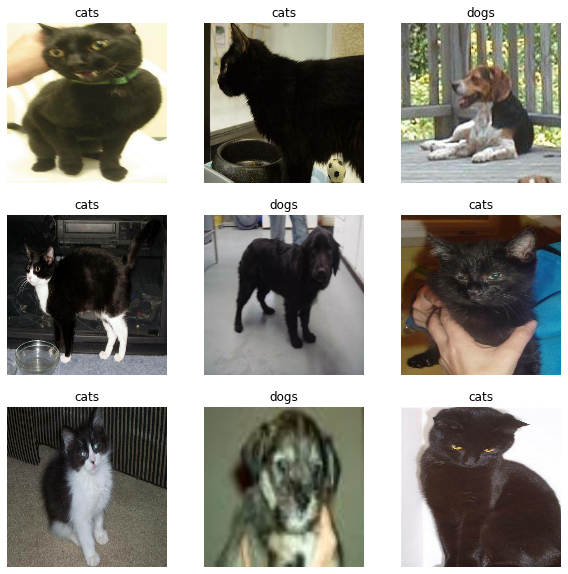

In [8]:
plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

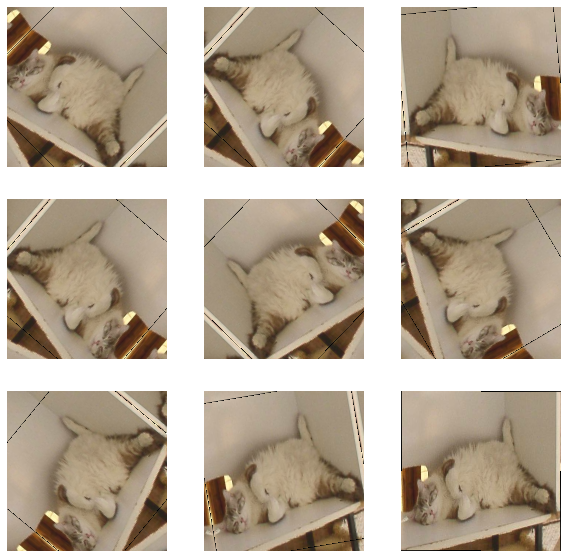

In [9]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10,10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis("off")

## Create Model

In [10]:
IMG_SHAPE = IMG_SIZE + (3,)
BASE_LEARNING_RATE = 0.0001
FINE_TUNING_RATE = 1e-5

### Feature Extractor

In [11]:
base_model = tf.keras.applications.efficientnet.EfficientNetB7(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 5, 5, 2560])

### Classification Head

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
feature_batch_average.shape

TensorShape([32, 2560])

In [14]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
prediction_batch.shape

TensorShape([32, 1])

### Compile

In [15]:
model_inputs = tf.keras.Input(shape=IMG_SHAPE)
_x = data_augmentation(model_inputs)
_x = tf.keras.applications.efficientnet.preprocess_input(_x)
_x = base_model(_x, training=False)
_x = global_average_layer(_x)
_x = tf.keras.layers.Dropout(0.2)(_x)
model_outputs = prediction_layer(_x)
model = tf.keras.Model(model_inputs, model_outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=BASE_LEARNING_RATE),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, 5, 5, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2561      
Total params: 64,100,248
Trainable params: 2,561
Non-trainable params: 64,097,687
______________________________________

In [16]:
len(model.trainable_variables)

2

## Training

### Top layer

In [17]:
INITIAL_EPOCHS = 10
INITIAL_EPOCHS__PARTIAL = 2

In [18]:
loss0, accuracy0 = model.evaluate(validation_dataset)

print(f"Initial loss: {loss0:.2f}")
print(f"Initial accuracy: {accuracy0:.2f}")

26/26 [==============================] - 41s 2s/step - loss: 0.6697 - binary_accuracy: 0.5173
Initial loss: 0.67
Initial accuracy: 0.52


In [19]:
model.save("./models/untrained")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./models/untrained/assets


In [20]:
history__init_partial = model.fit(
    train_dataset,
    epochs=INITIAL_EPOCHS__PARTIAL,
    validation_data=validation_dataset,
)

Epoch 1/2
63/63 [==============================] - 138s 2s/step - loss: 0.5870 - binary_accuracy: 0.5730 - val_loss: 0.4987 - val_binary_accuracy: 0.6200
Epoch 2/2
63/63 [==============================] - 139s 2s/step - loss: 0.4706 - binary_accuracy: 0.7195 - val_loss: 0.3844 - val_binary_accuracy: 0.8267


In [21]:
model.save("./models/init_partial")

INFO:tensorflow:Assets written to: ./models/init_partial/assets


In [22]:
history__init = model.fit(
    train_dataset,
    epochs=INITIAL_EPOCHS,
    initial_epoch=history__init_partial.epoch[-1],
    validation_data=validation_dataset,
)

Epoch 2/10
63/63 [==============================] - 141s 2s/step - loss: 0.3892 - binary_accuracy: 0.8130 - val_loss: 0.3135 - val_binary_accuracy: 0.8899
Epoch 3/10
63/63 [==============================] - 142s 2s/step - loss: 0.3279 - binary_accuracy: 0.8775 - val_loss: 0.2588 - val_binary_accuracy: 0.9356
Epoch 4/10
63/63 [==============================] - 140s 2s/step - loss: 0.2921 - binary_accuracy: 0.9030 - val_loss: 0.2258 - val_binary_accuracy: 0.9493
Epoch 5/10
63/63 [==============================] - 148s 2s/step - loss: 0.2654 - binary_accuracy: 0.9075 - val_loss: 0.2044 - val_binary_accuracy: 0.9592
Epoch 6/10
63/63 [==============================] - 144s 2s/step - loss: 0.2446 - binary_accuracy: 0.9165 - val_loss: 0.1804 - val_binary_accuracy: 0.9666
Epoch 7/10
63/63 [==============================] - 138s 2s/step - loss: 0.2230 - binary_accuracy: 0.9255 - val_loss: 0.1665 - val_binary_accuracy: 0.9666
Epoch 8/10
63/63 [==============================] - 138s 2s/step - los

In [23]:
model.save("./models/init_full")

INFO:tensorflow:Assets written to: ./models/init_full/assets


### Fine Tuning

In [24]:
FINE_TUNE_EPOCHS = 2

In [25]:
base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(FINE_TUNING_RATE),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, 5, 5, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2561      
Total params: 64,100,248
Trainable params: 63,789,521
Non-trainable params: 310,727
____________________________________

In [26]:
len(model.trainable_variables)

711

In [27]:
history__fine_tune = model.fit(
    train_dataset,
    epochs=INITIAL_EPOCHS + FINE_TUNE_EPOCHS,
    initial_epoch=history__init.epoch[-1],
    validation_data=validation_dataset,
)

Epoch 10/12
63/63 [==============================] - 520s 8s/step - loss: 0.1339 - binary_accuracy: 0.9510 - val_loss: 0.0609 - val_binary_accuracy: 0.9827
Epoch 11/12
63/63 [==============================] - 495s 8s/step - loss: 0.0722 - binary_accuracy: 0.9750 - val_loss: 0.0459 - val_binary_accuracy: 0.9827
Epoch 12/12
63/63 [==============================] - 494s 8s/step - loss: 0.0512 - binary_accuracy: 0.9845 - val_loss: 0.0412 - val_binary_accuracy: 0.9851


In [28]:
model.save("./models/final")

INFO:tensorflow:Assets written to: ./models/final/assets


## Prediction

In [29]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

In [30]:
model_output = model.predict(
    image_batch
).flatten()
predictions_sigmoid = tf.nn.sigmoid(model_output)
predictions_confidence = tf.abs(predictions_sigmoid - 0.5) / 0.5
predictions = tf.cast(tf.round(predictions_sigmoid), tf.int32).numpy()

In [31]:
print('Logits:\n', model_output)
print('Sigmoids:\n', predictions_sigmoid.numpy())
print('Confidence:\n', predictions_confidence.numpy())
print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

Logits:
 [-7.1236863  3.158862   6.0548835 -8.381773  -2.012896  -8.104799
 -3.4949403  4.934249   6.3471665  6.1830945  6.389275  -7.3537025
  7.101685  -1.8688378 -5.992965   5.2253604 -6.8215976 -6.151213
  5.684216  -6.2019134 -7.002337  -4.124885   6.4524856 -5.91747
 -5.430263   4.947227  -5.694754   8.049013   7.769303  -7.2016664
 -8.088869   4.864384 ]
Sigmoids:
 [8.0510974e-04 9.5925653e-01 9.9765909e-01 2.2894144e-04 1.1785555e-01
 3.0201674e-04 2.9456526e-02 9.9285555e-01 9.9825144e-01 9.9794024e-01
 9.9832332e-01 6.3979626e-04 9.9917698e-01 1.3367623e-01 2.4900138e-03
 9.9465036e-01 1.0887384e-03 2.1263063e-03 9.9661231e-01 2.0214915e-03
 9.0894103e-04 1.5908211e-02 9.9842584e-01 2.6848018e-03 4.3627918e-03
 9.9294704e-01 3.3522844e-03 9.9968064e-01 9.9957764e-01 7.4476004e-04
 3.0681491e-04 9.9234253e-01]
Confidence:
 [0.9983898  0.91851306 0.9953182  0.9995421  0.7642889  0.99939597
 0.94108695 0.9857111  0.9965029  0.9958805  0.99664664 0.9987204
 0.99835396 0.73264754 

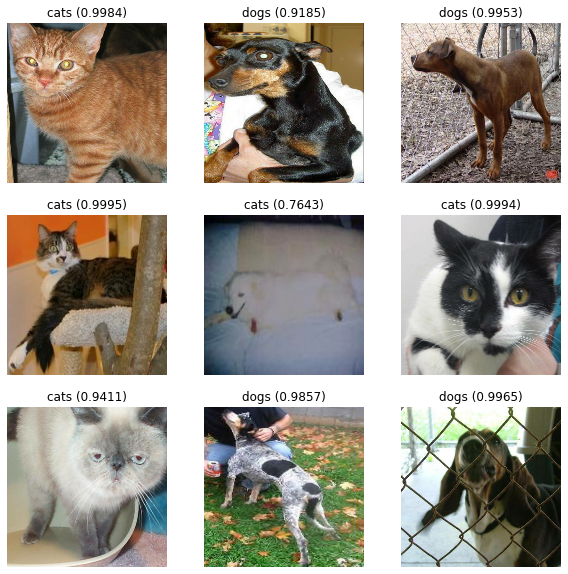

In [32]:
plt.figure(figsize=(10,10))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(f"{class_names[predictions[i]]} ({predictions_confidence[i]:.4f})")
    plt.axis("off")

## References

* https://www.tensorflow.org/guide/keras/transfer_learning
* https://www.tensorflow.org/tutorials/images/transfer_learning